# 循环神经网络

到目前为止，我们遇到过两种类型的数据：表格数据和图像数据。
对于图像数据，我们设计了专门的卷积神经网络架构来为这类特殊的数据结构建模。
换句话说，如果我们拥有一张图像，我们需要有效地利用其像素位置，
假若我们对图像中的像素位置进行重排，就会对图像中内容的推断造成极大的困难。

最重要的是，到目前为止我们默认数据都来自于某种分布，
并且所有样本都是独立同分布的
（independently and identically distributed，i.i.d.）。
然而，大多数的数据并非如此。
例如，文章中的单词是按顺序写的，如果顺序被随机地重排，就很难理解文章原始的意思。
同样，视频中的图像帧、对话中的音频信号以及网站上的浏览行为都是有顺序的。
因此，针对此类数据而设计特定模型，可能效果会更好。

另一个问题来自这样一个事实：
我们不仅仅可以接收一个序列作为输入，而是还可能期望继续猜测这个序列的后续。
例如，一个任务可以是继续预测$2, 4, 6, 8, 10, \ldots$。
这在时间序列分析中是相当常见的，可以用来预测股市的波动、
患者的体温曲线或者赛车所需的加速度。
同理，我们需要能够处理这些数据的特定模型。

简言之，如果说卷积神经网络可以有效地处理空间信息，
那么本章的*循环神经网络*（recurrent neural network，RNN）则可以更好地处理序列信息。
循环神经网络通过引入状态变量存储过去的信息和当前的输入，从而可以确定当前的输出。

许多使用循环网络的例子都是基于文本数据的，因此我们将在本章中重点介绍语言模型。
在对序列数据进行更详细的回顾之后，我们将介绍文本预处理的实用技术。
然后，我们将讨论语言模型的基本概念，并将此讨论作为循环神经网络设计的灵感。
最后，我们描述了循环神经网络的梯度计算方法，以探讨训练此类网络时可能遇到的问题。


# 序列模型

想象一下有人正在看网飞（Netflix，一个国外的视频网站）上的电影。
一名忠实的用户会对每一部电影都给出评价，
毕竟一部好电影需要更多的支持和认可。
然而事实证明，事情并不那么简单。
随着时间的推移，人们对电影的看法会发生很大的变化。
事实上，心理学家甚至对这些现象起了名字：

* *锚定*（anchoring）效应：基于其他人的意见做出评价。
  例如，奥斯卡颁奖后，受到关注的电影的评分会上升，尽管它还是原来那部电影。
  这种影响将持续几个月，直到人们忘记了这部电影曾经获得的奖项。
  结果表明（ `Wu.Ahmed.Beutel.ea.2017`），这种效应会使评分提高半个百分点以上。
* *享乐适应*（hedonic adaption）：人们迅速接受并且适应一种更好或者更坏的情况
  作为新的常态。
  例如，在看了很多好电影之后，人们会强烈期望下部电影会更好。
  因此，在许多精彩的电影被看过之后，即使是一部普通的也可能被认为是糟糕的。
* *季节性*（seasonality）：少有观众喜欢在八月看圣诞老人的电影。
* 有时，电影会由于导演或演员在制作中的不当行为变得不受欢迎。
* 有些电影因为其极度糟糕只能成为小众电影。*Plan9from Outer Space*和*Troll2*就因为这个原因而臭名昭著的。

简而言之，电影评分决不是固定不变的。
因此，使用时间动力学可以得到更准确的电影推荐 `Koren.2009`。
当然，序列数据不仅仅是关于电影评分的。
下面给出了更多的场景。

* 在使用程序时，许多用户都有很强的特定习惯。
  例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
* 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。
  毕竟，先见之明比事后诸葛亮难得多。
  在统计学中，前者（对超出已知观测范围进行预测）称为*外推法*（extrapolation），
  而后者（在现有观测值之间进行估计）称为*内插法*（interpolation）。
* 在本质上，音乐、语音、文本和视频都是连续的。
  如果它们的序列被我们重排，那么就会失去原有的意义。
  比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
* 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，
  这些余震的强度比非大地震后的余震要大得多。
  事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
* 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。

## 统计工具

处理序列数据需要统计工具和新的深度神经网络架构。
为了简单起见，我们以股票价格（富时100指数）为例。

![近30年的富时100指数](https://zh.d2l.ai/_images/ftse100.png)


其中，用$x_t$表示价格，即在*时间步*（time step）
$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### 自回归模型

为了实现这个预测，交易员可以使用回归模型，
仅有一个主要问题：输入数据的数量，
输入$x_{t-1}, \ldots, x_1$本身因$t$而异。
也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，
因此需要一个近似方法来使这个计算变得容易处理。
本章后面的大部分内容将围绕着如何有效估计
$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。
简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列
$x_{t-1}, \ldots, x_1$可能是不必要的，
因此我们只需要满足某个长度为$\tau$的时间跨度，
即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。
当下获得的最直接的好处就是参数的数量总是不变的，
至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。
这种模型被称为*自回归模型*（autoregressive models），
因为它们是对自己执行回归。

第二种策略，
是保留一些对过去观测的总结$h_t$，
并且同时更新预测$\hat{x}_t$和总结$h_t$。
这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，
以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。
由于$h_t$从未被观测到，这类模型也被称为
*隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](https://zh.d2l.ai/_images/sequence-model.svg)

这两种情况都有一个显而易见的问题：如何生成训练数据？
一个经典方法是使用历史观测来预测下一个未来观测。
显然，我们并不指望时间会停滞不前。
然而，一个常见的假设是虽然特定值$x_t$可能会改变，
但是序列本身的动力学不会改变。
这样的假设是合理的，因为新的动力学一定受新的数据影响，
而我们不可能用目前所掌握的数据来预测新的动力学。
统计学家称不变的动力学为*静止的*（stationary）。
因此，整个序列的估计值都将通过以下的方式获得：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），
而不是连续的数字，则上述的考虑仍然有效。
唯一的差别是，对于离散的对象，
我们需要使用分类器而不是回归模型来估计$P(x_t \mid  x_{t-1}, \ldots, x_1)$。

### 马尔可夫模型

回想一下，在自回归模型的近似法中，
我们使用$x_{t-1}, \ldots, x_{t-\tau}$
而不是$x_{t-1}, \ldots, x_1$来估计$x_t$。
只要这种是近似精确的，我们就说序列满足*马尔可夫条件*（Markov condition）。
特别是，如果$\tau = 1$，得到一个
*一阶马尔可夫模型*（first-order Markov model），
$P(x)$由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$$

当假设$x_t$仅是离散值时，这样的模型特别棒，
因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。
例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：
$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。
隐马尔可夫模型中的动态规划超出了本节的范围
（我们将在 :numref:`sec_bi_rnn`再次遇到），
而动态规划这些计算工具已经在控制算法和强化学习算法广泛使用。

### 因果关系

原则上，将$P(x_1, \ldots, x_T)$倒序展开也没什么问题。
毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，
我们还可以得到一个反向的条件概率分布。
然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。
很明显，未来的事件不能影响过去。
因此，如果我们改变$x_t$，可能会影响未来发生的事情$x_{t+1}$，但不能反过来。
也就是说，如果我们改变$x_t$，基于过去事件得到的分布不会改变。
因此，解释$P(x_{t+1} \mid x_t)$应该比解释$P(x_t \mid x_{t+1})$更容易。
例如，在某些情况下，对于某些可加性噪声$\epsilon$，
显然我们可以找到$x_{t+1} = f(x_t) + \epsilon$，
而反之则不行`Hoyer.Janzing.Mooij.ea.2009`。
而这个向前推进的方向恰好也是我们通常感兴趣的方向。
彼得斯等人 `Peters.Janzing.Scholkopf.2017`
对该主题的更多内容做了详尽的解释，而我们的上述讨论只是其中的冰山一角。

## 训练

在了解了上述统计工具后，让我们在实践中尝试一下！
首先，我们生成一些数据：(**使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$。**)


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

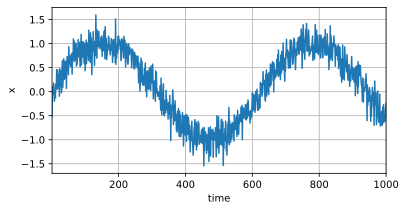

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里，我们[**使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。


In [6]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备[**训练模型**]了。实现下面的训练代码的方式与前面几节中的循环训练基本相同。因此，我们不会深入探讨太多细节。


In [7]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.091064
epoch 2, loss: 0.060320
epoch 3, loss: 0.053630
epoch 4, loss: 0.051812
epoch 5, loss: 0.050343


## 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查[**模型预测下一个时间步**]的能力，
也就是*单步预测*（one-step-ahead prediction）。


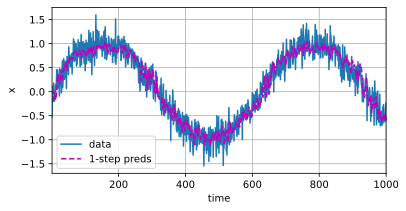

In [8]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
让我们看看效果如何。


In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

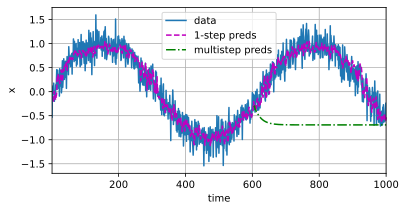

In [10]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。
我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们[**更仔细地看一下$k$步预测**]的困难。


In [11]:
max_steps = 64

In [12]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

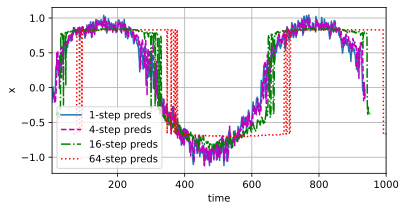

In [13]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

## 小结

- 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
- 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
- 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。



# 文本预处理

对于序列数据处理问题，评估了所需的统计工具和预测时面临的挑战。
这样的数据存在许多种形式，文本是最常见例子之一。
例如，一篇文章可以被简单地看作一串单词序列，甚至是一串字符序列。
本节中，我们将解析文本的常见预处理步骤。
这些步骤通常包括：

1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。


In [1]:
import collections
import re
from d2l import torch as d2l

## 读取数据集

首先，我们从H.G.Well的[时光机器](https://www.gutenberg.org/ebooks/35)中加载文本。
这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀，
而现实中的文档集合可能会包含数十亿个单词。
下面的函数(**将数据集读取到由多条文本行组成的列表中**)，其中每条文本行都是一个字符串。
为简单起见，我们在这里忽略了标点符号和字母大写。


In [2]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元化

下面的`tokenize`函数将文本行列表（`lines`）作为输入，
列表中的每个元素是一个文本序列（如一条文本行）。
[**每个文本序列又被拆分成一个词元列表**]，*词元*（token）是文本的基本单位。
最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。


In [3]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 词表

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。
现在，让我们[**构建一个字典，通常也叫做*词表*（vocabulary），
用来将字符串类型的词元映射到从$0$开始的数字索引中**]。
我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，
得到的统计结果称之为*语料*（corpus）。
然后根据每个唯一词元的出现频率，为其分配一个数字索引。
很少出现的词元通常被移除，这可以降低复杂性。
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“&lt;unk&gt;”。
我们可以选择增加一个列表，用于保存那些被保留的词元，
例如：填充词元（“&lt;pad&gt;”）；
序列开始词元（“&lt;bos&gt;”）；
序列结束词元（“&lt;eos&gt;”）。


In [4]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

我们首先使用时光机器数据集作为语料库来[**构建词表**]，然后打印前几个高频词元及其索引。


In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


现在，我们可以(**将每一条文本行转换成一个数字索引列表**)。


In [6]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 整合所有功能

在使用上述函数时，我们[**将所有功能打包到`load_corpus_time_machine`函数中**]，
该函数返回`corpus`（词元索引列表）和`vocab`（时光机器语料库的词表）。
我们在这里所做的改变是：

1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；
1. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的`corpus`仅处理为单个列表，而不是使用多词元列表构成的一个列表。


In [7]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 小结

- 文本是序列数据的一种最常见的形式之一。
- 为了对文本进行预处理，我们通常将文本拆分为词元，构建词表将词元字符串映射为数字索引，并将文本数据转换为词元索引以供模型操作。

